In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import os
from pathlib import Path
from pytorch_fid import fid_score
import matplotlib.pyplot as plt
import seaborn as sns
import lpips
import clip
import torch
from PIL import Image


def get_images_paths_by_folder(folder_path: str):
    image_paths = []
    with os.scandir(folder_path) as entries:
        for entry in entries:
            if entry.name.lower().endswith((".jpg", ".png")) and entry.is_file():
                image_paths.append(entry.path)

    print("Изображения:", image_paths)
    return image_paths

In [2]:
# разрешение фото в директории
def get_image_resolutions(folder_path):
    """Рекурсивно собирает разрешения всех изображений в папке и подпапках."""
    widths, heights = [], []
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

    # Рекурсивный поиск изображений
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                img_path = Path(root) / file
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        widths.append(width)
                        heights.append(height)
                except Exception as e:
                    print(f"Ошибка при открытии {img_path}: {e}")

    if not widths or not heights:
        print("Нет изображений в указанной директории.")
        return None, None, None

    # Вычисляем статистику
    avg_width = sum(widths) / len(widths)
    avg_height = sum(heights) / len(heights)
    max_res = (max(widths), max(heights))
    min_res = (min(widths), min(heights))

    return (avg_width, avg_height), max_res, min_res


folder_paths = [
    r"D:\MY_PROJECTS\diplom_hse\train_models\data_yolo_03_01",
    r"D:\MY_PROJECTS\diplom_hse\train_models\data_yolo_05_04",
    r"D:\MY_PROJECTS\diplom_hse\train_models\data_yolo_12_04",
]
for folder_path in folder_paths:
    avg_res, max_res, min_res = get_image_resolutions(folder_path)
    print(f"Папка: {folder_path}")
    if avg_res:
        print(f"Среднее разрешение: {int(avg_res[0])}x{int(avg_res[1])}")
        print(f"Максимальное разрешение: {max_res[0]}x{max_res[1]}")
        print(f"Минимальное разрешение: {min_res[0]}x{min_res[1]}")

Папка: D:\MY_PROJECTS\diplom_hse\train_models\data_yolo_03_01
Среднее разрешение: 605x467
Максимальное разрешение: 640x482
Минимальное разрешение: 266x334
Папка: D:\MY_PROJECTS\diplom_hse\train_models\data_yolo_05_04
Среднее разрешение: 599x465
Максимальное разрешение: 640x480
Минимальное разрешение: 340x326
Папка: D:\MY_PROJECTS\diplom_hse\train_models\data_yolo_12_04
Среднее разрешение: 580x461
Максимальное разрешение: 640x480
Минимальное разрешение: 236x226


# FID

In [3]:
def get_fid_by_paths(
    paths: list[str]
):

    fid = fid_score.calculate_fid_given_paths(
        paths, batch_size=32, device="cuda", dims=2048, num_workers=1
    )
    return fid

In [ ]:
matrixes = []
basic_path = r"D:\MY_PROJECTS\diplom_hse\train_models\prepared_data_2"


for subset in ["train", "val", "test"]:
    # Матрица FID (5x5, так как классы 1-5)
    fid_matrix = np.zeros((5, 5))

    for estetica_class_1 in range(1, 6):
        for estetica_class_2 in range(1, 6):
            print(subset, estetica_class_1, estetica_class_2)
            if estetica_class_1 == estetica_class_2:
                fid_matrix[estetica_class_1 - 1, estetica_class_2 - 1] = 0
            else:
                path_1 = os.path.join(basic_path, subset, str(estetica_class_1))
                path_2 = os.path.join(basic_path, subset, str(estetica_class_2))
                fid = get_fid_by_paths([path_1, path_2])
                fid_matrix[estetica_class_1 - 1, estetica_class_2 - 1] = fid

    matrixes.append(fid_matrix)
    # Визуализация heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        fid_matrix,
        annot=True,
        fmt=".1f",
        cmap="YlOrRd",
        xticklabels=[f"Class {i}" for i in range(1, 6)],
        yticklabels=[f"Class {i}" for i in range(1, 6)],
    )
    plt.title(f"FID между классами (subset: {subset})")
    plt.xlabel("Класс 2")
    plt.ylabel("Класс 1")
    plt.show()

# t-SNE

Изображения: ['D:\\MY_PROJECTS\\diplom_hse\\train_models\\prepared_data_2\\train\\1\\43bc90b2-1772-11f0-ad6b-ced717198e39.jpg', 'D:\\MY_PROJECTS\\diplom_hse\\train_models\\prepared_data_2\\train\\1\\4ebe755c-1772-11f0-ad6b-ced717198e39.jpg', 'D:\\MY_PROJECTS\\diplom_hse\\train_models\\prepared_data_2\\train\\1\\4ed883ca-1772-11f0-ad6b-ced717198e39.jpg', 'D:\\MY_PROJECTS\\diplom_hse\\train_models\\prepared_data_2\\train\\1\\4ef297f6-1772-11f0-ad6b-ced717198e39.jpg', 'D:\\MY_PROJECTS\\diplom_hse\\train_models\\prepared_data_2\\train\\1\\4f022928-1772-11f0-ad6b-ced717198e39.jpg', 'D:\\MY_PROJECTS\\diplom_hse\\train_models\\prepared_data_2\\train\\1\\4ff16088-1772-11f0-ad6b-ced717198e39.jpg', 'D:\\MY_PROJECTS\\diplom_hse\\train_models\\prepared_data_2\\train\\1\\51307952-1772-11f0-ad6b-ced717198e39.jpg', 'D:\\MY_PROJECTS\\diplom_hse\\train_models\\prepared_data_2\\train\\1\\6e1b99de-1772-11f0-ad6b-ced717198e39.jpg', 'D:\\MY_PROJECTS\\diplom_hse\\train_models\\prepared_data_2\\train\\1\\6e6

C:\Users\Kirill\AppData\Local\Temp\ipykernel_6492\1417012380.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  embs.append(np.array(image_features.squeeze().cpu()))


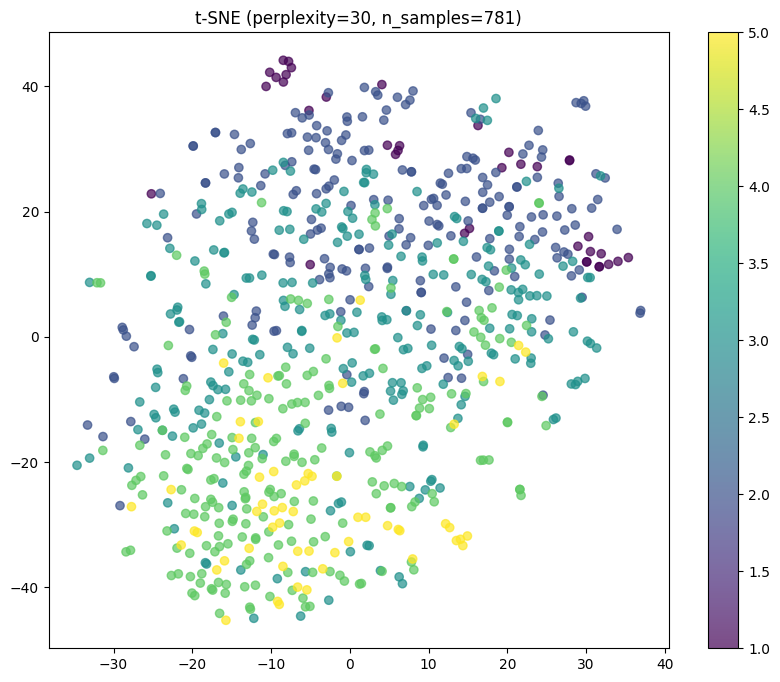

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os


def extract_features(image_paths: list[str]):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    embs = []
    for image_path in image_paths:
        img = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = model.encode_image(img)  # Эмбеддинг изображения (512D)
        embs.append(np.array(image_features.squeeze().cpu()))
    return embs

def plot_tsne(features, labels):
    """Визуализация t-SNE"""
    # Автонастройка perplexity
    n_samples = len(features)
    perplexity = min(30, max(5, n_samples // 3))

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42).fit_transform(
        features
    )

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter)
    plt.title(f"t-SNE (perplexity={perplexity}, n_samples={n_samples})")
    plt.show()


train_images_1 = get_images_paths_by_folder(
    r"D:\MY_PROJECTS\diplom_hse\train_models\prepared_data_2\train\1"
)
train_images_2 = get_images_paths_by_folder(
    r"D:\MY_PROJECTS\diplom_hse\train_models\prepared_data_2\train\2"
)
train_images_3 = get_images_paths_by_folder(
    r"D:\MY_PROJECTS\diplom_hse\train_models\prepared_data_2\train\3"
)
train_images_4 = get_images_paths_by_folder(
    r"D:\MY_PROJECTS\diplom_hse\train_models\prepared_data_2\train\4"
)
train_images_5 = get_images_paths_by_folder(
    r"D:\MY_PROJECTS\diplom_hse\train_models\prepared_data_2\train\5"
)

# Извлечение признаков
features_train_1 = extract_features(train_images_1)
features_train_2 = extract_features(train_images_2)
features_train_3 = extract_features(train_images_3)
features_train_4 = extract_features(train_images_4)
features_train_5 = extract_features(train_images_5)


# Объединение и метки
all_features = np.vstack(
    [
        features_train_1,
        features_train_2,
        features_train_3,
        features_train_4,
        features_train_5,
    ]
)
labels = np.array(
    [1] * len(features_train_1)
    + [2] * len(features_train_2)
    + [3] * len(features_train_3)
    + [4] * len(features_train_4)
    + [5] * len(features_train_5)
)  # 0=Real, 1=Pred

plot_tsne(all_features, labels)